In [1]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, make_scorer,confusion_matrix
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)


## 1. Load data

In [2]:
import pandas as pd

df = pd.read_csv('diabetes_kaggle.csv')

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Exploratory data analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
features = df.columns[0:-1]
label = df.columns[-1]

for feature in features:
    if feature != 'Pregnancies':
        df.loc[df[feature] <= 0, feature] = np.nan

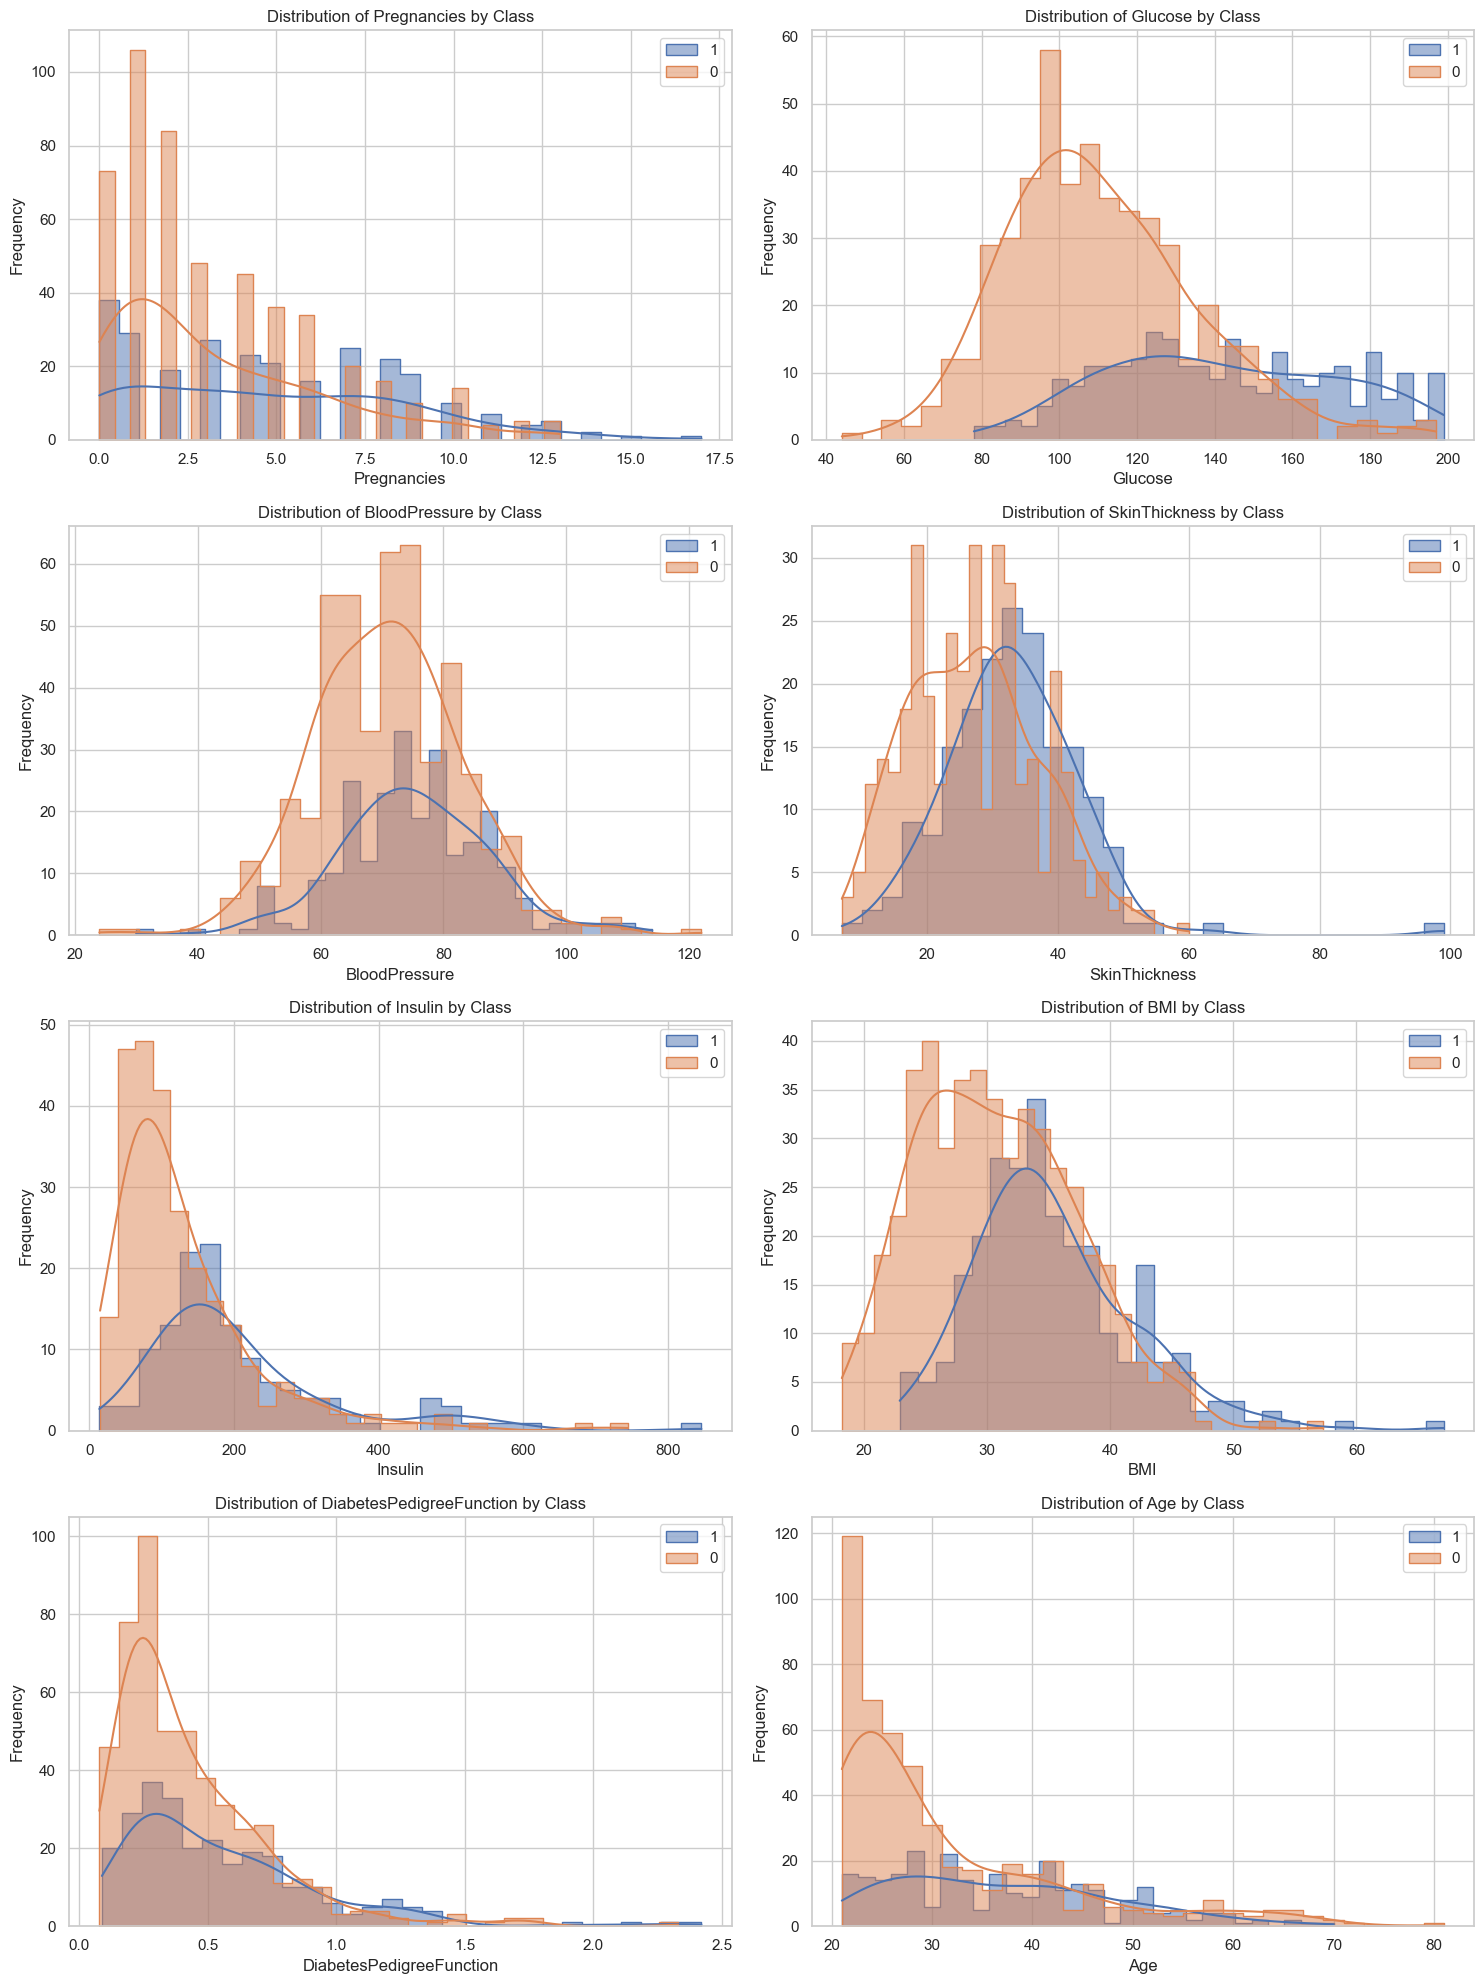

In [6]:
sns.set(style="whitegrid")

# Determine the number of rows needed for the subplots based on the number of features
n_features = len(features)
n_rows = (n_features + 1) // 2  # Now calculating rows for 2 columns

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, n_rows * 5)) 
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each feature to create individual plots
for i, feature in enumerate(features):
    ax = axes[i]  # Get the current axis for the subplot
    for label_class in df[label].unique():
        subset = df[df[label] == label_class]
        sns.histplot(subset[feature], bins=30, kde=True, label=f'{label_class}', element="step", fill=True, ax=ax)
    
    ax.set_title(f'Distribution of {feature} by Class')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()

# Turn off unused subplots if features do not perfectly fill the grid
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

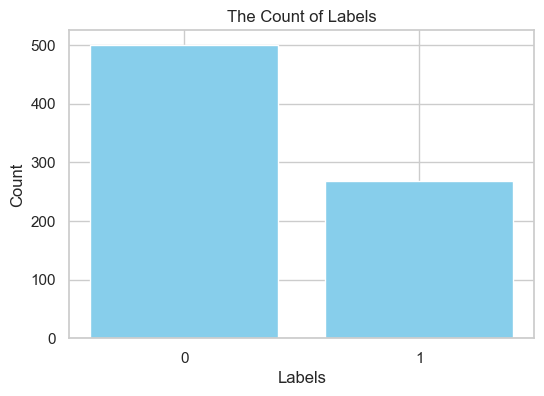

In [7]:
label_counts = df['Outcome'].value_counts()

# Plot the bar chart
plt.figure(figsize=(6, 4))  # Set the figure size
plt.bar(["0", "1"], label_counts.values, color='skyblue')

# Adding labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('The Count of Labels')

# Display the plot
plt.show()

## 3. Prepare data and Baseline models

In [8]:
X = df.drop('Outcome', axis=1)  # Features
y = df["Outcome"]  # Labels

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [9]:
preproc_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()) 
])

In [10]:
from sklearn.base import BaseEstimator

class Random_Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X, random_state=42):
        np.random.seed(random_state)
        return [np.random.choice([0, 1]) for i in range(X.shape[0])]

In [11]:
random_pl = Pipeline([
    ('preproc', preproc_pipeline), 
    ('random_clf', Random_Classifier()) 
])

In [12]:
def stratified_kfold_cv_and_metric(pipeline, X_train, y_train, model_name , n_splits=10, random_state=42):
    
    # Define the stratified K-fold cross-validator
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Lists to store metrics for each fold
    accuracies, balanced_accuracies, recalls, precisions, f1_scores, auc_scores, f01_scores, f10_scores = ([] for _ in range(8))
    
    # Initialize arrays to store all true and predicted labels for confusion matrix
    y_true_all = np.array([], dtype=int)
    y_pred_all = np.array([], dtype=int)
    
    # Perform stratified K-fold cross-validation
    for train_index, test_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Fit the pipeline on the training fold
        pipeline.fit(X_fold_train, y_fold_train)
        
        # Predict on the test fold
        y_pred = pipeline.predict(X_fold_test)
        
        # Store the true and predicted labels for all folds
        y_true_all = np.concatenate([y_true_all, y_fold_test])
        y_pred_all = np.concatenate([y_pred_all, y_pred])
        
        # Evaluate the predictions for the current fold and accumulate results
        accuracies.append(accuracy_score(y_fold_test, y_pred))
        balanced_accuracies.append(balanced_accuracy_score(y_fold_test, y_pred))
        recalls.append(recall_score(y_fold_test, y_pred, average='macro'))
        precisions.append(precision_score(y_fold_test, y_pred, average='macro', zero_division=0))
        f1_scores.append(f1_score(y_fold_test, y_pred, average='macro'))

    metrics_dict = {
    'Accuracy Mean': np.mean(accuracies),
    'Balanced Accuracy Mean': np.mean(balanced_accuracies),
    'Recall Mean': np.mean(recalls),
    'Precision Mean': np.mean(precisions),
    'F1 Score Mean': np.mean(f1_scores),
    }

    print(f"Accuracy - Mean: {np.mean(accuracies):.4f}, SD: {np.std(accuracies):.4f}")
    print(f"Balanced Accuracy - Mean: {np.mean(balanced_accuracies):.4f}, SD: {np.std(balanced_accuracies):.4f}")
    print(f"Recall - Mean: {np.mean(recalls):.4f}, SD: {np.std(recalls):.4f}")
    print(f"Precision - Mean: {np.mean(precisions):.4f}, SD: {np.std(precisions):.4f}")
    print(f"F1 Score - Mean: {np.mean(f1_scores):.4f}, SD: {np.std(f1_scores):.4f}")


    # Plot the confusion matrix for all data collected across folds
    cm = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=True, xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    return metrics_dict

The Baseline Random Classifier Metrics:
Accuracy - Mean: 0.5114, SD: 0.0473
Balanced Accuracy - Mean: 0.5142, SD: 0.0520
Recall - Mean: 0.5142, SD: 0.0520
Precision - Mean: 0.5129, SD: 0.0473
F1 Score - Mean: 0.5006, SD: 0.0484


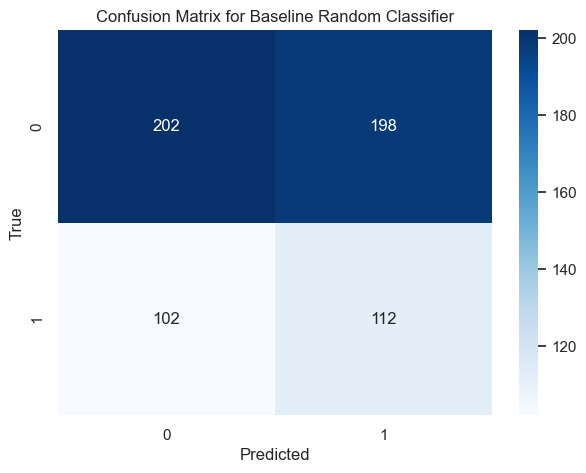

In [13]:
print("The Baseline Random Classifier Metrics:")
baseline_random_result = stratified_kfold_cv_and_metric(random_pl, X_train, y_train, 'Baseline Random Classifier')

In [14]:
perceptron_pl = Pipeline([
    ('preproc', preproc_pipeline),
    ('perceptron', Perceptron(random_state=42)) 
])

The Baseline Perceptron Classifier Metrics:
Accuracy - Mean: 0.7020, SD: 0.0515
Balanced Accuracy - Mean: 0.6820, SD: 0.0517
Recall - Mean: 0.6820, SD: 0.0517
Precision - Mean: 0.6862, SD: 0.0477
F1 Score - Mean: 0.6726, SD: 0.0548


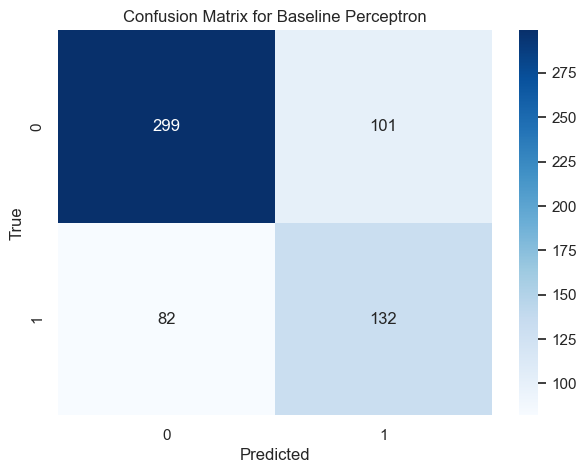

In [15]:
print("The Baseline Perceptron Classifier Metrics:")
baseline_perceptron_result = stratified_kfold_cv_and_metric(perceptron_pl, X_train, y_train, 'Baseline Perceptron')

## 4. Hyper-parameter optimisation

In [16]:
def Stratified_grid_search(pipeline, param_grid, X_train, y_train, n_splits=10, random_state=42):
    # Define the stratified K-fold cross-validator
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Define the scoring function using balanced accuracy
    scorer = make_scorer(balanced_accuracy_score)
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scorer, cv=skf, verbose=1)
    
    # Perform the grid search
    grid_search.fit(X_train, y_train)
    
    print("Best Score:", grid_search.best_score_)
    print("Best Params:", grid_search.best_params_)

    return grid_search.best_estimator_

param_grid = {
    'perceptron__penalty': [None, 'l2', 'l1', 'elasticnet'],  # Regularization types
    'perceptron__alpha': [0.00001, 0.0001, 0.001, 0.01],               # Regularization strength
    'perceptron__max_iter': [50, 125, 250, 500, 1000],                # Max iterations
    'perceptron__tol': [1e-3, 1e-4, 1e-5],                   # Tolerance for stopping
    'perceptron__eta0': [1.0, 0.1, 0.01, 0.001]                    # Initial learning rate
}

In [17]:
best_perceptron = Stratified_grid_search(perceptron_pl, param_grid, X_train, y_train)

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


Best Score: 0.7292045454545454
Best Params: {'perceptron__alpha': 1e-05, 'perceptron__eta0': 0.1, 'perceptron__max_iter': 50, 'perceptron__penalty': 'elasticnet', 'perceptron__tol': 0.001}


The Best Perceptron Classifier Metrics:
Accuracy - Mean: 0.7557, SD: 0.0307
Balanced Accuracy - Mean: 0.7292, SD: 0.0377
Recall - Mean: 0.7292, SD: 0.0377
Precision - Mean: 0.7379, SD: 0.0325
F1 Score - Mean: 0.7276, SD: 0.0356


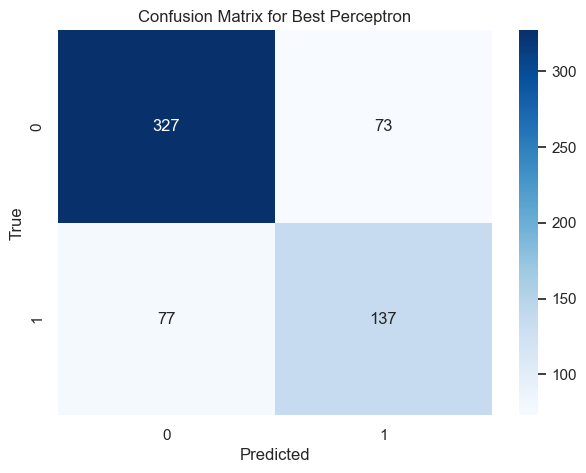

In [18]:
print("The Best Perceptron Classifier Metrics:")
best_perceptron_result = stratified_kfold_cv_and_metric(best_perceptron, X_train, y_train, 'Best Perceptron')

## 5. Final results

In [19]:
def test_the_model(model, X_test, y_test, model_name='Model'):
    
    # Predict the labels for X_test
    y_pred = model.predict(X_test)
        
    # Calculate and print metrics
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=True, xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

Accuracy: 0.7078
Balanced Accuracy: 0.6515
Recall: 0.6515
Precision: 0.6766
F1 Score: 0.6575


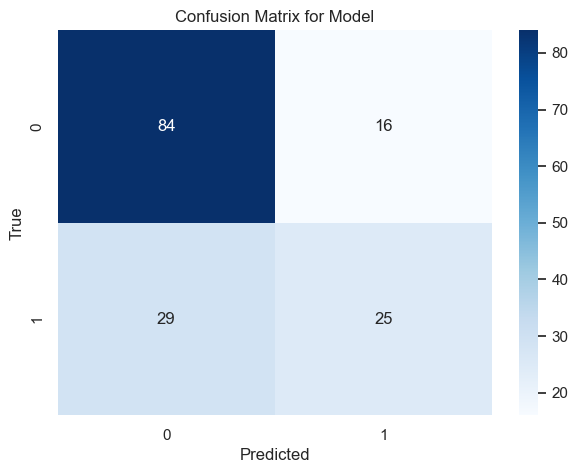

In [20]:
test_the_model(best_perceptron, X_test, y_test)